In [1]:
import numpy as np
import pandas as pd
from DAME_FLAME import *
from new_db import FLAME_db_new
from FLAME_db_orig import FLAME_db
import numpy as np
import pandas as pd
import pyodbc
import time
import pickle
import operator
from operator import itemgetter
from joblib import Parallel, delayed

from sklearn import linear_model

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from sqlalchemy import create_engine
from tqdm import tqdm
import matplotlib.pyplot as plt
import mysql.connector
import psycopg2
import sqlite3
%matplotlib inline

In [3]:
def connect_db(select_db, database_name, host, port, user, password, driver):
    conn = None;
    if select_db == "MySQL":
        conn = mysql.connector.connect(host=host,
                                        port=port,
                                        user=user,
                                        password=password,
                                        database=database_name)
    elif select_db == "postgreSQL":
        conn = psycopg2.connect(host=host,
                                port=port,
                                user=user,
                                password=password,
                                database=database_name)
        
    elif select_db == "Microsoft SQL server":
        conn = pyodbc.connect('DRIVER='+driver+
                              '; SERVER='+host+
                              ';DATABASE='+database_name+
                              ';UID='+user+
                              ';PWD='+ password)
    else:
        raise Exception("please select the database you are using "\
                        "frame in parameter 'input_data'")

    cur = conn.cursor()
    return cur,conn

def insert_data_to_db(table_name,data,treatment_column_name,outcome_column_name,
                      select_db,database_name,host,user,password,port = None,driver = None):
    
    table = table_name
    cur,conn = connect_db(select_db = select_db, database_name=database_name, host = host, 
                       port = port, user=user, password= password,driver = driver)


    data['matched'] = [0]*data.shape[0]
    colnames = data.columns
    cur.execute('drop table if exists {}'.format(table))


    col_setup =""
    for i in range(len(colnames)):
        v = colnames[i]
        if v == outcome_column_name:
            col_setup += v + ' float(53)'
        else :
            col_setup += v + ' int'
        if i != len(colnames) - 1:
            col_setup += ','
    cur.execute('CREATE TABLE ' + table +  '('+ col_setup+');')

    for i in range(data.shape[0]):
        col = ','.join(['{0}'.format(v) for v in colnames])
        values = ','.join(['{0}'.format(v) for v in data.iloc[i]])
        cur.execute('INSERT INTO '+  table +'('+ col +') VALUES (' + values + ')')
        
    conn.commit()
    print('Insert {} rows successfully to Database'.format(data.shape[0]))
    
    
def ATE_db(res_post):
    MG_weight = 0
    MG_weight_total = 0
    ATE_total = 0
    for i in range(len(res_post[1])):
        if type((res_post[1][i])) != type(None):  
            MGs = res_post[1][i]
            for j in range(MGs.shape[0]):
                MG = MGs.iloc[j]
                MG_weight = MG['count_c'] + MG['count_t']
                ATE_total += MG_weight* (MG['effect_t'] - MG['effect_c'])
                MG_weight_total += MG_weight

    ATE = ATE_total/MG_weight_total           
    return ATE

In [4]:
def gen_data_db(n = 250,p = 5, TE = 1):
    if p <= 2:
        print("p should be larger than 2")
        return None

    covs = np.random.binomial(1,0.5,size=(n,p))
    treated = np.random.binomial(1, 0.5, size = n)
    outcome = 15 * covs[:, 1] - 10 * covs[:, 2] + 5 * covs[:, 3] + TE * treated + np.random.normal(size = n)

    data = np.append(covs, treated.reshape(-1,1), axis=1)
    data = np.append(data, outcome.reshape(-1,1), axis=1)
    col_names = ['cov' + str(i+1) for i in range(p)] + ['Treated', 'outcome123']
    data = pd.DataFrame(data)
    data.columns = col_names 
    return data

def gen_data_neg(n = 250,p = 5, TE = 1,verbose = False):
    n = int(n)
    p = int(p)
    if p <= 2:
        print("p should be larger than 2")
        return None
    covs = np.random.binomial(1,0.5,size=(n,p))
    treated = np.random.binomial(1, 0.5, size = n)
    outcome = np.random.normal(size = n) + TE *treated
    for i in range(p):
        if i % 3 == 0:
            outcome += (-1)*covs[:,i]
        else:
            outcome += covs[:,i]

            
    data = np.append(covs, treated.reshape(-1,1), axis=1)
    data = np.append(data, outcome.reshape(-1,1), axis=1)
    col_names = ['cov' + str(i+1) for i in range(p)] + ['Treated', 'outcome123']
    data = pd.DataFrame(data)
    data.columns = col_names 
    return data    

#Generate dataset with exponential and Power  Decay
def gen_data_db_exp(n = 250,p = 5,TE = 1, verbose = True):
    n = int(n)
    p = int(p)
    if p <= 2:
        print("p should be larger than 2")
        return None
    covs = np.random.binomial(1,0.5,size=(n,p))
    treated = np.random.binomial(1, 0.5, size = n)
    outcome = np.random.normal(size = n) + TE *treated
    for i in range(p):
        if verbose:
            outcome += 5*(1/2)**(i+1)*covs[:,i]
        else:
            outcome += 5*(1/(i+1))*covs[:,i]
            
    data = np.append(covs, treated.reshape(-1,1), axis=1)
    data = np.append(data, outcome.reshape(-1,1), axis=1)
    col_names = ['cov' + str(i+1) for i in range(p)] + ['Treated', 'outcome123']
    data = pd.DataFrame(data)
    data.columns = col_names 
    return data


def gen_data_db_intersection(n = 250,p = 5,TE = 1, verbose = True):
    n = int(n)
    p = int(p)
    if p <= 2:
        print("p should be larger than 2")
        return None
    covs = np.random.binomial(1,0.5,size=(n,p))
    treated = np.random.binomial(1, 0.5, size = n)
    outcome = np.random.normal(size = n) + TE *treated
    for i in range(p):
        if i !=0:
            outcome += covs[:,i]*covs[:,i-1]
            
    data = np.append(covs, treated.reshape(-1,1), axis=1)
    data = np.append(data, outcome.reshape(-1,1), axis=1)
    col_names = ['cov' + str(i+1) for i in range(p)] + ['Treated', 'outcome123']
    data = pd.DataFrame(data)
    data.columns = col_names 
    return data


In [ ]:
list_TE = [5.21]
# list_TE = [0.1]
# list_mysql_new = []
# list_mysql = []
list_post_new = []
list_post = []
list_bit = []
list_post_new_time = []
list_post_time = []
list_bit_time = []
list_micro_time = []
list_micro = []
n = 5000
p = 30

for j in range(2):
    for p in tqdm([60]):
    # list_n = [500,5000,10000]
        list_n_ = [1.5e6] #from tqdm import tqdm
        for n in list_n_:
            for TE in list_TE:
                data = gen_data_db_exp(n = n,p = p, TE = TE,verbose = False)
                holdout = gen_data_db_exp(n = 3000,p = p, TE = TE,verbose = False)

                insert_data_to_db("test_df", # The name of your table containing the dataset to be matched
                                    data, 
                                    treatment_column_name= "Treated",
                                    outcome_column_name= 'outcome123',
                                    select_db = "postgreSQL",  # Select the database you are using
                                    database_name='tmp', # database name
                                    host = "localhost",
                                    port = "5432",
                                    user="newuser",
                                    password= "sunxian123")

#                 insert_data_to_db( "test_df", # The name of your table containing the dataset to be matched
#                         data, 
#                         treatment_column_name= "Treated",
#                         outcome_column_name= 'outcome123',
#                         select_db = "Microsoft SQL server",  # Select the database you are using
#                         database_name='tmp', # database name
#                         host = "localhost",
#                         user="sa",
#                         password= 'reallyStrongPwd123',
#                         driver = '/usr/local/lib/libmsodbcsql.17.dylib'
#                       )

#                 s = time.time()
    #             res_post = FLAME_db(input_data = "test_df", # The name of your table containing the dataset to be matched
    #                             holdout_data = holdout, # holdout set
    #                             treatment_column_name= "Treated",
    #                             outcome_column_name= 'outcome123',
    #                             reg_param = 0, # reg_param*(num_treated_MG/total_treated  + num_control_MG/total_control)
    #                             select_db = "postgreSQL",  # Select the database you are using
    #                             database_name='tmp', # database name
    #                             host = "localhost",
    #                             port = "5432",
    #                             user="newuser",
    #                             password= "sunxian123")
    #             list_post_time.append(time.time() - s)
#                 res_micro = FLAME_db_new(input_data = "test_df", # The name of your table containing the dataset to be matched
#                                 holdout_data = holdout, # holdout set
#                                 treatment_column_name= "Treated",
#                                 outcome_column_name= 'outcome123',
#                                 reg_param = 0,
#                                 select_db = "Microsoft SQL server",  # Select the database you are using
#                                 database_name='tmp', # database name
#                                 host = "localhost",
#                                 user="sa",
#                                 password= 'reallyStrongPwd123',
#                                 driver = '/usr/local/lib/libmsodbcsql.17.dylib'
#                                 )
#                 list_micro_time.append(time.time() - s)
                s = time.time()
                res_post_new = FLAME_db_new(input_data = "test_df", # The name of your table containing the dataset to be matched
                                holdout_data = holdout, # holdout set
                                treatment_column_name= "Treated",
                                outcome_column_name= 'outcome123',
                                reg_param = 0,
                                select_db = "postgreSQL",  # Select the database you are using
                                database_name='tmp', # database name
                                host = "localhost",
                                port = "5432",
                                user="newuser",
                                password= "sunxian123")
                list_post_new_time.append(time.time() - s)


    #             ate_post = ATE_db(res_post) - TE
                ate_post_new = ATE_db(res_post_new) - TE
#                 ate_micro = ATE_db(res_micro) - TE

                list_post_new.append(ate_post_new)
#                 list_micro.append(ate_micro )
    #             list_post.append(ate_post)



  0%|          | 0/1 [00:00<?, ?it/s]

Insert 1500000 rows successfully to Database
Done Matching


  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
print(list_post_new_time)
print(list_micro_time)

[41.055094957351685, 86.73369789123535, 178.7235288619995]
[41.50398588180542, 151.28012895584106, 291.8286249637604]


In [27]:
print(list_post_new)
print(list_micro)

[0.004242599949422221, -0.01563105955316768, -0.004740521281409116]
[0.004242599949422221, -0.015631059553166793, -0.0047405212814028985]


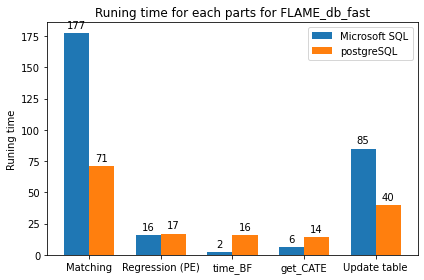

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Matching', 'Regression (PE)', 'time_BF', 'get_CATE', 'Update table']
men_means = list(map(int, res_micro[0]))
women_means = list(map(int, res_post_new[0]))
s_means = [1, 2, 33,10, 2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Microsoft SQL')
rects2 = ax.bar(x + width/2, women_means, width, label='postgreSQL')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Runing time')
ax.set_title('Runing time for each parts for FLAME_db_fast')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



fig.tight_layout()

plt.show()

In [77]:
# from matplotlib import pyplot as plt 

# for i in range(3):
#     s =  i*10
#     e =  10 + i*10
#     plt.title("Dataset with " + str(list_n[i]) + ' units and 30 covariates')
#     plt.plot(list_TE, list_post_new[s:e],'-o', label = 'bd_fast')
#     plt.plot(list_TE, list_post[s:e],'-o', label = 'db')
#     plt.plot(list_TE,list_bit[s:e],'-o',label = 'bit' )
#     plt.plot(list_TE,list_TE,'-o',label = 'True TE')
#     plt.xlabel("True TE")
#     plt.ylabel("Estimated ATE")
#     plt.legend()
#     plt.show()

In [101]:

# Some other example server values are
# server = 'localhost\sqlexpress' # for a named instance
# server = 'myserver,port' # to specify an alternate port
server = '127.0.0.1' 
database = 'tmp' 
username = 'sa' 
password = 'reallyStrongPwd123' 
conn = pyodbc.connect('DRIVER=/usr/local/lib/libmsodbcsql.17.dylib;SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cur = conn.cursor()
# conn = pyodbc.connect("Driver={ODBC Driver 17 for SQL Server};"
#                     "Server=localhost;"
#                     "Database=tmp;"
#                     "Trusted_Connection=yes;")

# cur = conn.cursor()

# engine = create_engine('mssql+pyodbc://localhost/master?driver=SQL+Server+Native+Client+11.0')

# df,betas,eff_coef = data_generation_dense_2(10000, 10000, 10, 5)
# holdout_df,_,_ = data_generation_dense_2(10000, 10000, 10, 5)
# db_name = 'db'
# cur.execute('drop table if exists {}'.format(db_name))
# conn.commit()

# df.to_sql(db_name, engine)

# res = run_db(db_name, holdout_df, 15)
# pickle.dump(res, open('FLAME-db-result', 'wb'))
# ## --above is an example

In [9]:
TE = 5.21
data = gen_data_db_exp(n = 1000,p = 30, TE = TE,verbose = False)
holdout = gen_data_db_exp(n = 1000,p = 30, TE = TE,verbose = False)


In [12]:
insert_data_to_db( "test_df", # The name of your table containing the dataset to be matched
                    data, # holdout set
                    treatment_column_name= "Treated",
                    outcome_column_name= 'outcome123',
                    select_db = "Microsoft SQL server",  # Select the database you are using
                    database_name='tmp', # database name
                    host = "localhost",
                    user="sa",
                    password= 'reallyStrongPwd123',
                    driver = '/usr/local/lib/libmsodbcsql.17.dylib'
                  )

Insert 1000 rows successfully to Database


In [ ]:
server = '127.0.0.1' 
database = 'tmp' 
username = 'sa' 
driver =' /usr/local/lib/libmsodbcsql.17.dylib'
password = 'reallyStrongPwd123' 
conn = pyodbc.connect('DRIVER='+driver+'; SERVER='+host+';DATABASE='+database_name+';UID='+user+';PWD='+ password)
cur = conn.cursor()

In [13]:
 res = FLAME_db_new(input_data = "test_df", # The name of your table containing the dataset to be matched
            holdout_data = holdout, # holdout set
            treatment_column_name= "Treated",
            outcome_column_name= 'outcome123',
            reg_param = 0,
            select_db = "Microsoft SQL server",  # Select the database you are using
            database_name='tmp', # database name
            host = "localhost",
            user="sa",
            password= 'reallyStrongPwd123',
            driver = '/usr/local/lib/libmsodbcsql.17.dylib'
            )


Done Matching


In [48]:
e_fast = abs(np.array([0.03501655, 
0.00820785,
0.0000559698703179734,
0.0000142013468701248,
])) +  abs(np.array([0.029875616853710873,
-0.013223077167201502, 
0.0014885824719579333,
-0.00019830572118006984
])) + abs(np.array([0.0203053701493916, 
0.027673826272817337, 
-0.0005668120016588674,
0.0022254319492249763,
]))
+abs(np.array([-0.1260421432627501, 
-0.009511875621776689, 
-0.0035483864180783087,
0.0012953631576486657
]))

e_ = abs(np.array([0.0122997 ,
 0.00328512,
-0.0006968287666406781,
-0.0000942013468701248
])) +  abs(np.array([0.017350532622314674,
-0.0036441326842826527, 
-0.000697328603834535,
-0.00009939690204241458
])) + abs(np.array([0.024171848666521, 
0.004106038173197213, 
-0.0030819709005349694,
0.0029325616806605836
]))
+abs(np.array([-0.10629171305673601, 
-0.014596269349462787, 
0.001312882734850973,
-0.0008981416653544017
]))

array([0.12604214, 0.00951188, 0.00354839, 0.00129536])

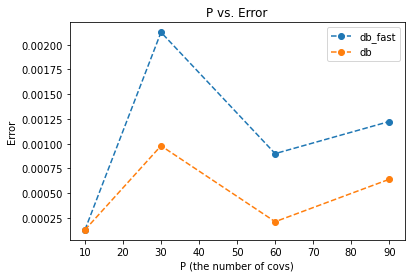

In [58]:
t_fast = abs(np.array([-0.0001299598569461935, -0.0021253649629819904, 0.004300130493249732, 0.0012241595697277674]))

t_ = abs(np.array([-0.00012995985694796985, -0.0009790183047995171, -0.00021286750024707146, 0.0006411862134410029]))

p_ = [10,30,60,90]
plt.title("P vs. Error")
plt.plot(p_, t_fast,'--o', label = 'db_fast')
plt.plot(p_, t_ ,'--o', label = 'db')
plt.xlabel("P (the number of covs)")
plt.ylabel("Error")
plt.legend()
plt.show()

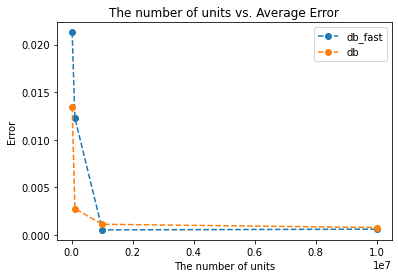

In [49]:

p_ = [1e4,1e5,1e6,1e7]
plt.title("The number of units vs. Average Error")
plt.plot(p_, e_fast/4,'--o', label = 'db_fast')
plt.plot(p_, e_/4 ,'--o', label = 'db')
plt.xlabel("The number of units")
plt.ylabel("Error")
plt.legend()
plt.show()

In [51]:
t_fast = abs(np.array([3.7937862873077393,
 19.2962429523468,
 246.541766166687,
 4990.943213701248])) 
+  abs(np.array([3.8023087978363037, 
20.09614610671997, 
341.06010031700134,
4948.775732040405
])) + abs(np.array([
3.93350887298584,
20.934993982315063, 
294.44100403785706,
4989.798572063446
]))
+abs(np.array([4.312711954116821, 
29.569446802139282, 
232.06820607185364,
5292.586167097092
]))

t__ = abs(np.array([
44.438103914260864,
 137.841717004776,
 1305.0056025981903,
 25284.803201198578])) 
+  abs(np.array([39.92817807197571,
136.60494208335876, 
1515.5449929237366,
23662.778589963913
])) 
+ abs(np.array([41.58702111244202, 
143.11609768867493, 
1360.463859319687,
25174.8752989769
]))
+abs(np.array([54.56232810020447, 
145.26342797279358, 
1393.2738950252533,
26490.64203071594
]))

array([   54.5623281 ,   145.26342797,  1393.27389503, 26490.64203072])

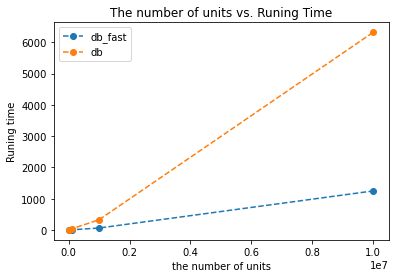

In [54]:

p_ = [1e4,1e5,1e6,1e7]
plt.title("The number of units vs. Runing Time")
plt.plot(p_, t_fast/4,'--o', label = 'db_fast')
plt.plot(p_, t__/4 ,'--o', label = 'db')
plt.xlabel("the number of units")
plt.ylabel("Runing time")
plt.legend()
plt.show()